In [1]:
!nvidia-smi

Tue Nov 26 10:29:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:73:00.0  On |                  Off |
| 30%   34C    P8              25W / 300W |    791MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install ultralytics roboflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output()
!yolo checks


Ultralytics 8.3.28 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA RTX A6000, 48669MiB)
Setup complete ✅ (104 CPUs, 187.5 GB RAM, 524.3/2818.3 GB disk)

OS                  Linux-5.15.0-125-generic-x86_64-with-glibc2.29
Environment         Linux
Python              3.8.10
Install             git
RAM                 187.53 GB
Disk                524.3/2818.3 GB
CPU                 Intel Xeon Platinum 8270 2.70GHz
CPU count           104
GPU                 NVIDIA RTX A6000, 48669MiB
GPU count           1
CUDA                11.8

numpy               ✅ 1.24.4>=1.23.0
matplotlib          ✅ 3.7.5>=3.3.0
opencv-python       ✅ 4.10.0.84>=4.6.0
pillow              ✅ 10.4.0>=7.1.2
pyyaml              ✅ 6.0.2>=5.3.1
requests            ✅ 2.32.3>=2.23.0
scipy               ✅ 1.10.1>=1.4.1
torch               ✅ 2.4.1+cu118>=1.8.0
torchvision         ✅ 0.19.1+cu118>=0.9.0
tqdm                ✅ 4.67.0>=4.64.0
psutil              ✅ 6.0.0
py-cpuinfo          ✅ 9.0.0
pandas              ✅ 2.0.3>=1.1.

## Load Dataset

Get the code from roboflow

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="TZjPTUl4HiDzYaDN4SWg")
project = rf.workspace("test-mhm3s").project("kudzu-in-gsv")
version = project.version(3)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Kudzu-in-GSV-3 in yolov8:: 100%|█| 496/496 [00


## Train Model

In [5]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=20 imgsz=512

New https://pypi.org/project/ultralytics/8.3.38 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.28 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA RTX A6000, 48669MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/student/Desktop/KudzuClassification/ObjectDetection/Kudzu-in-GSV-3/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classe

#### Confusion Matrix

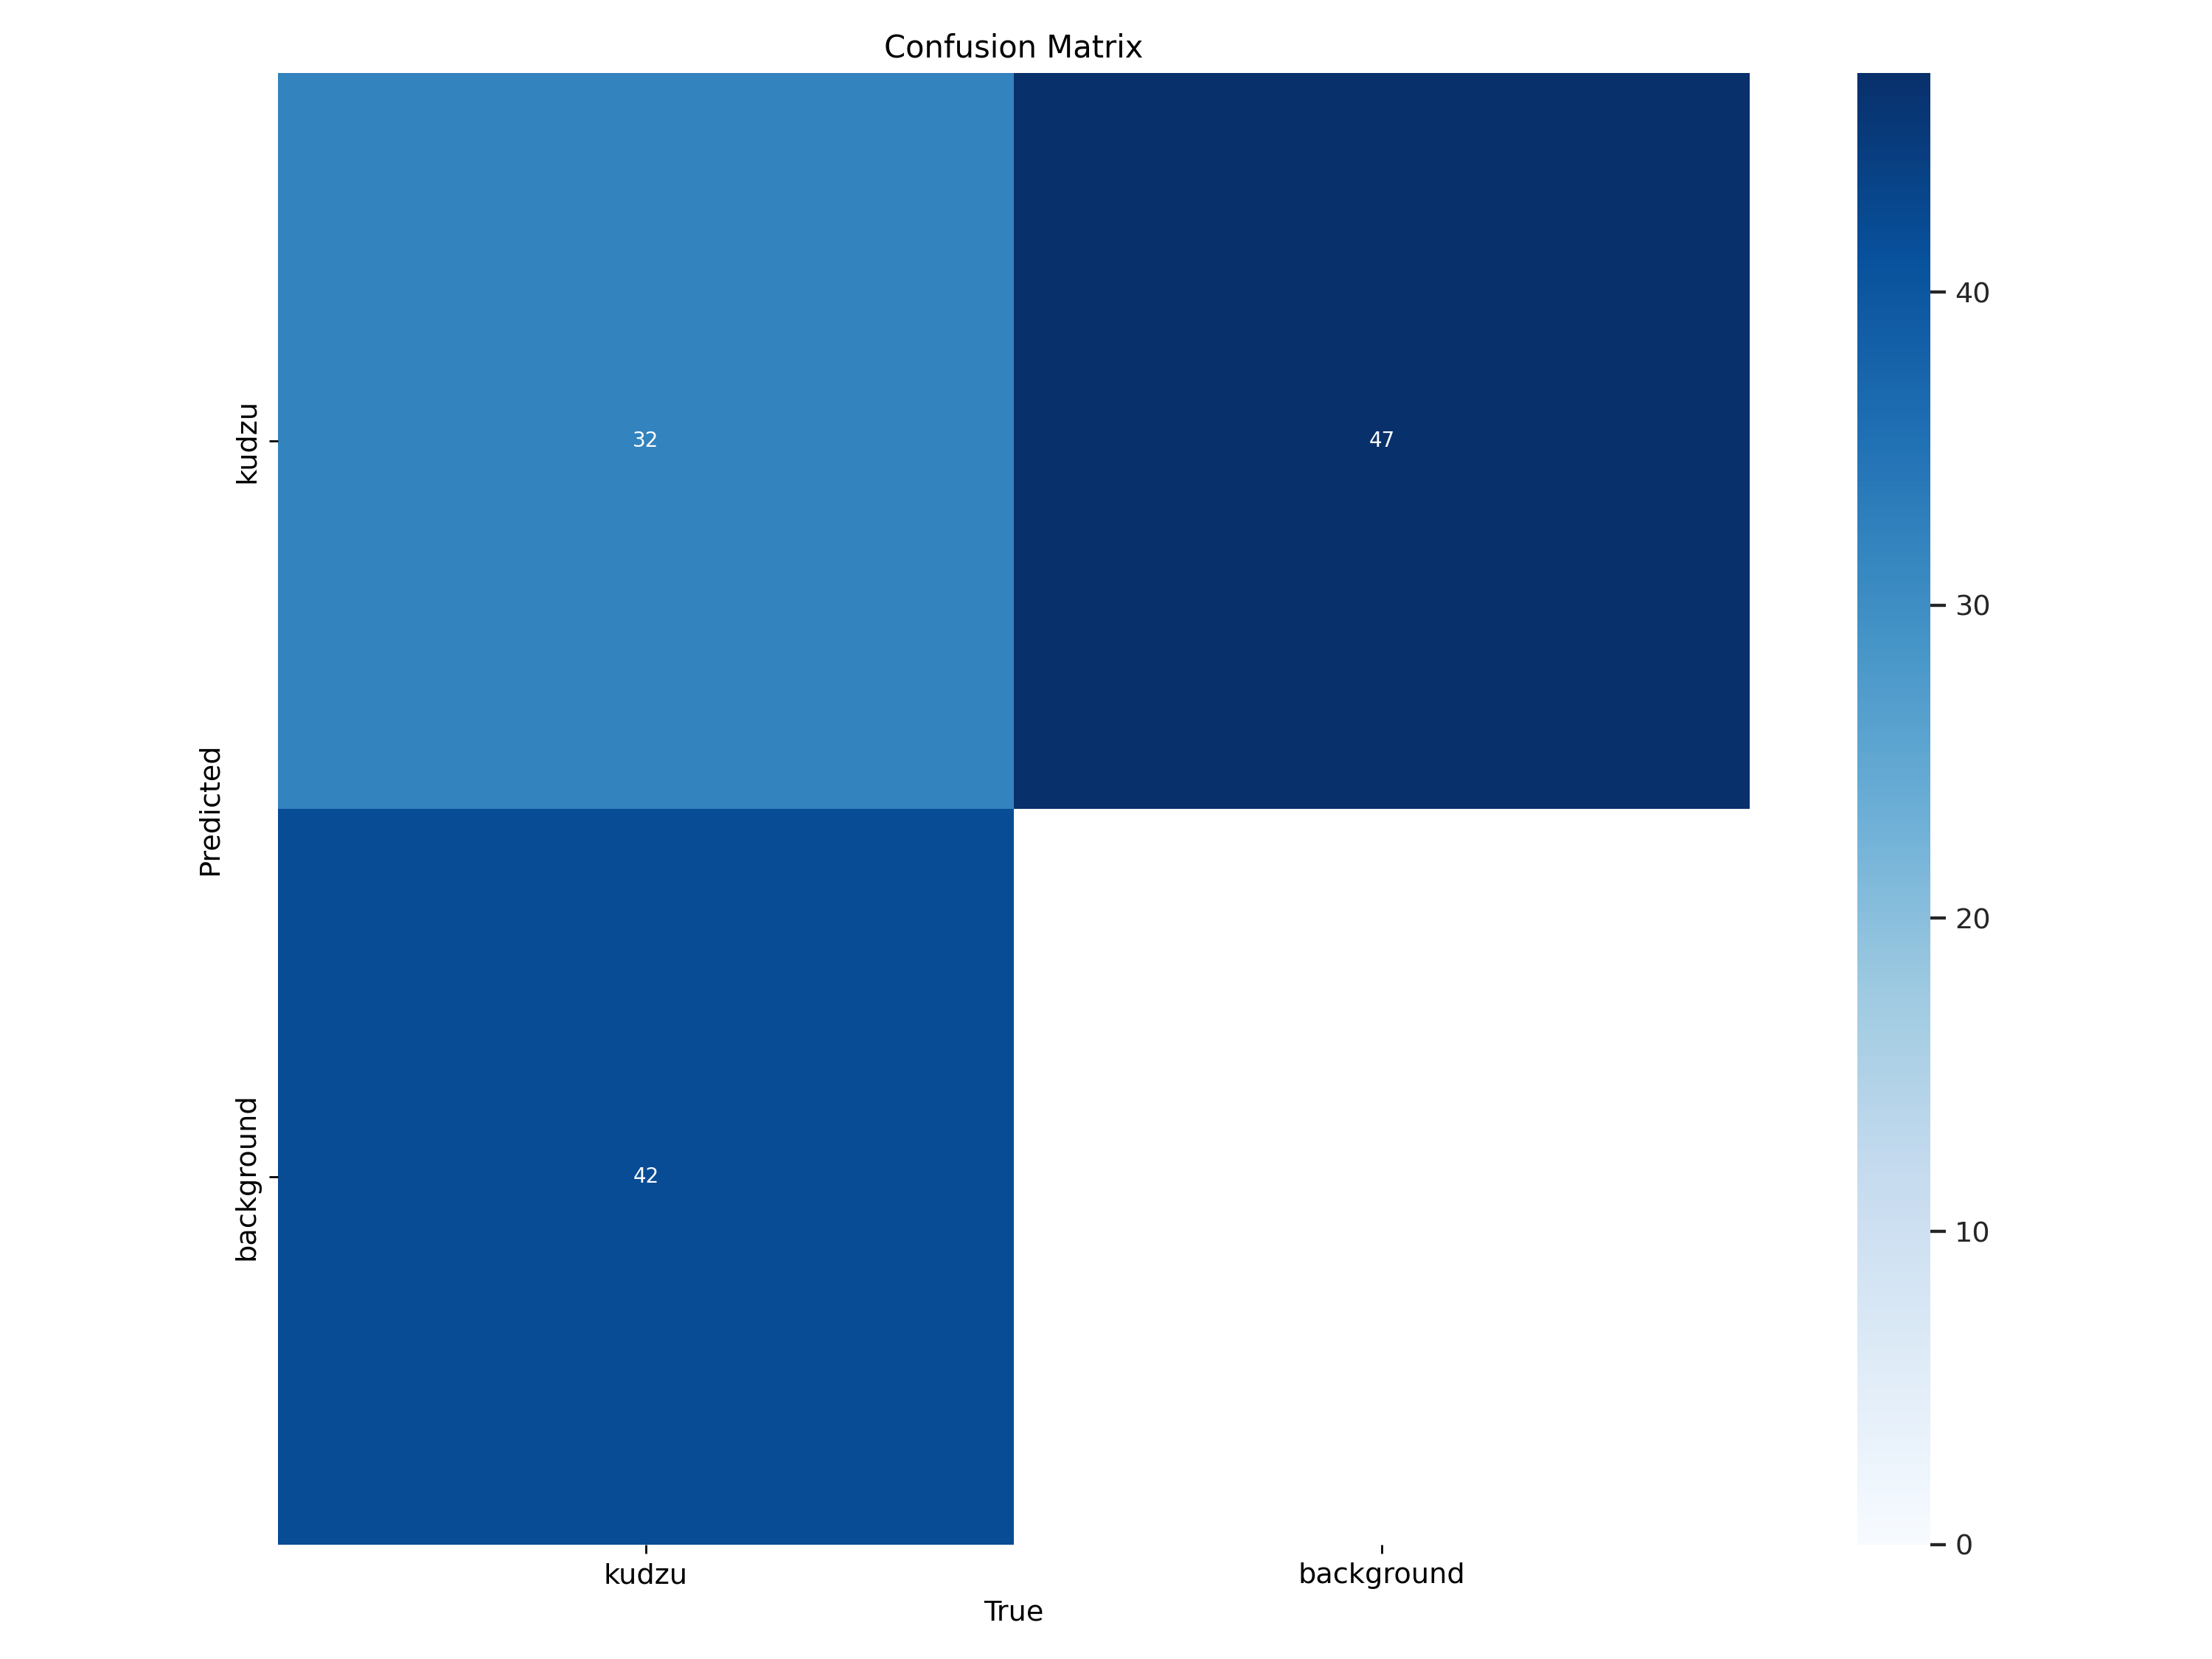

In [7]:
Image(filename='/home/student/Desktop/runs/detect/train2/confusion_matrix.png', width=600)

#### Train Results

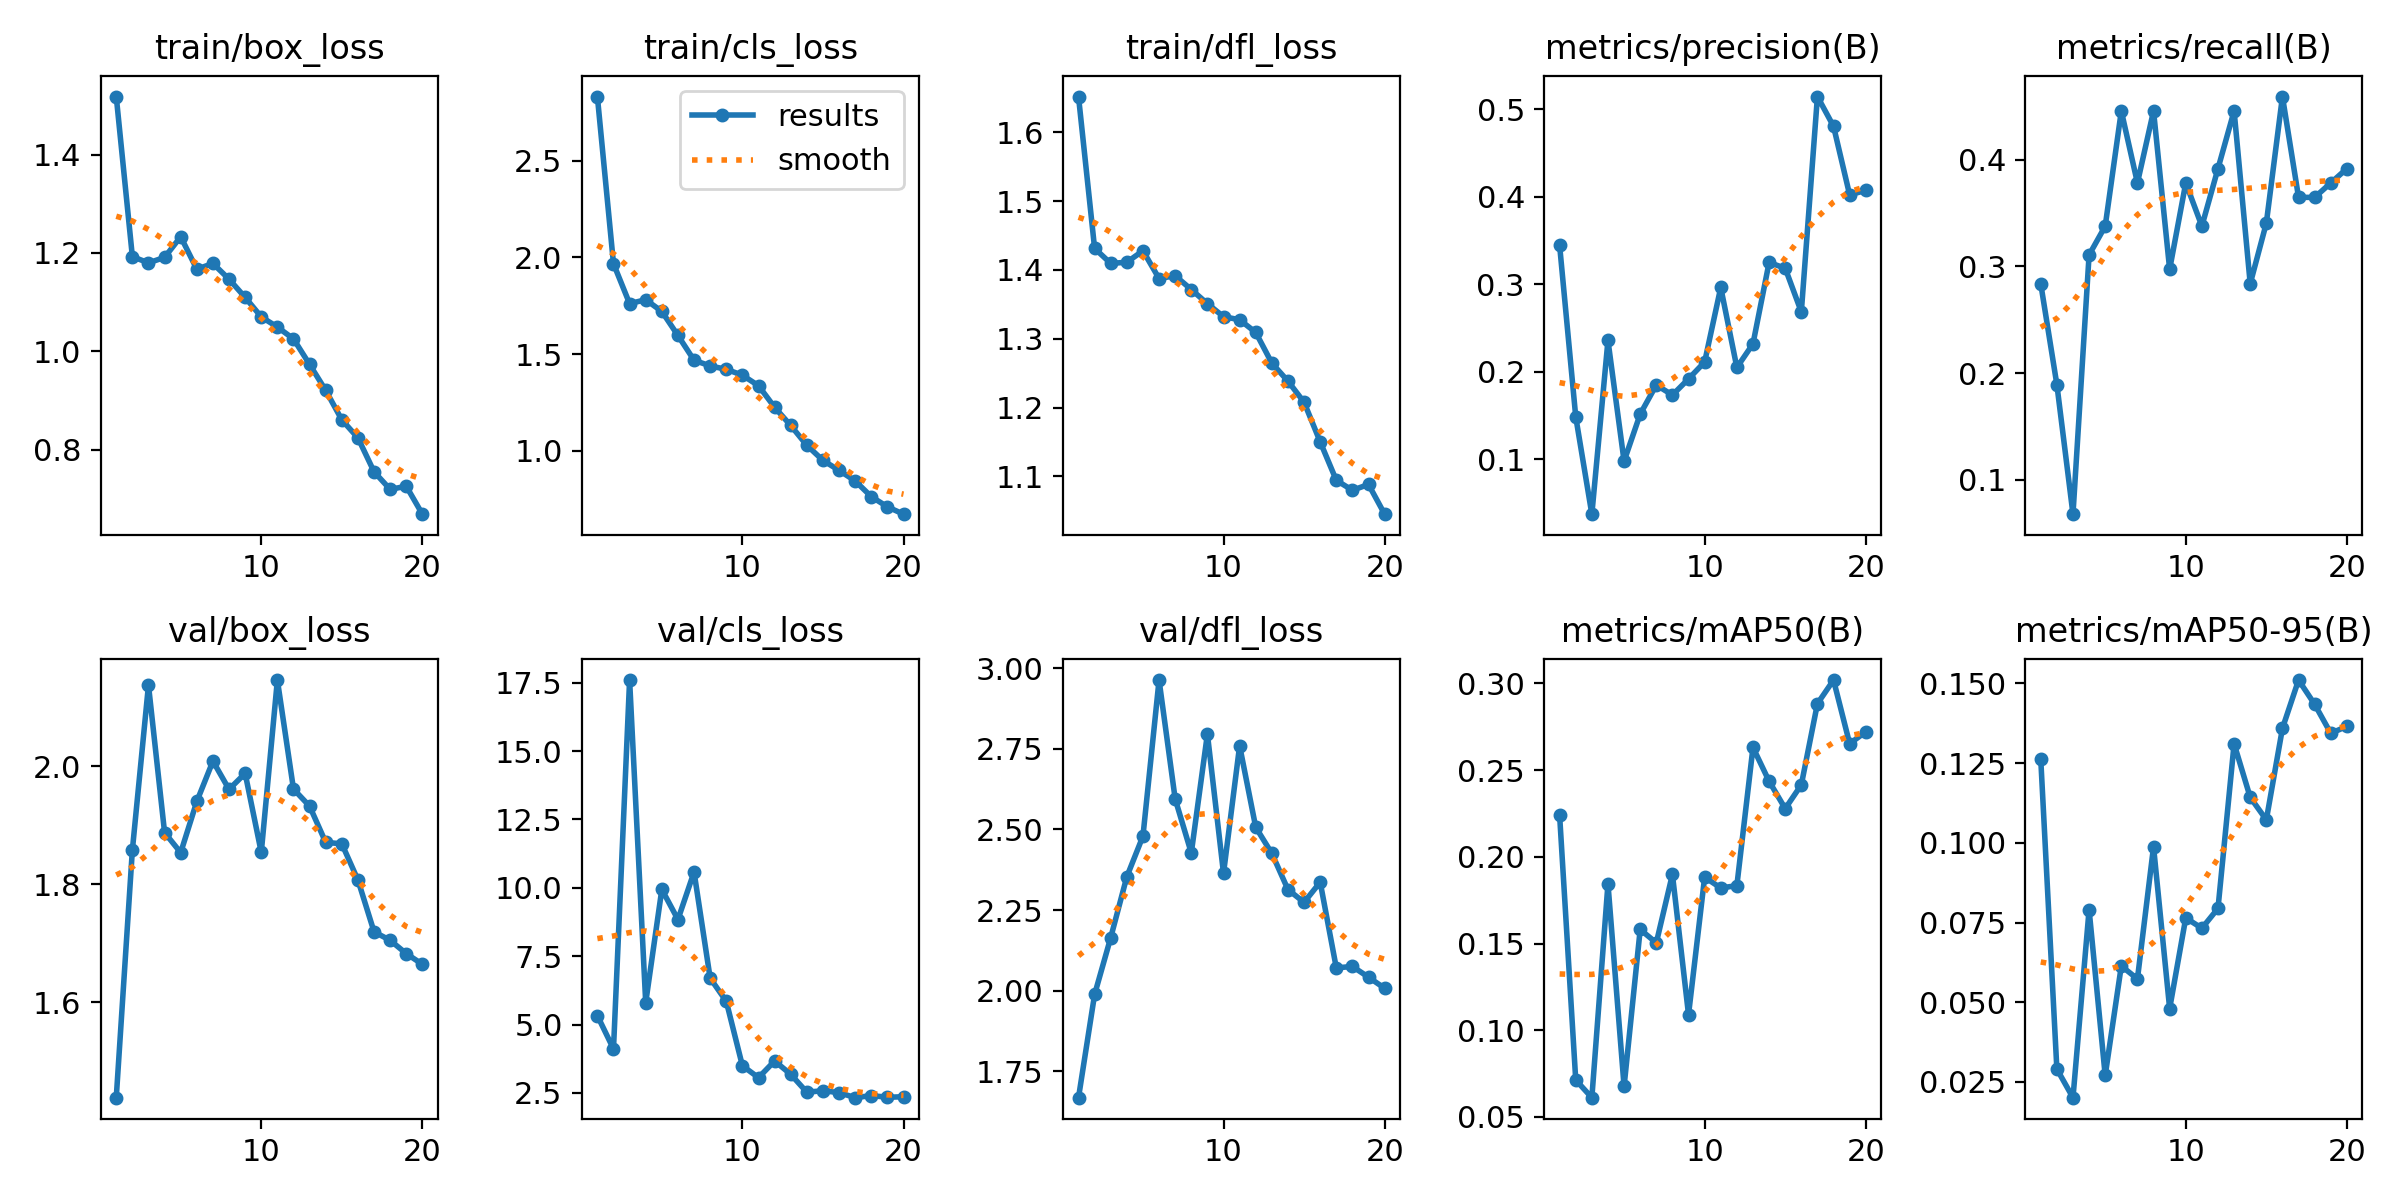

In [6]:
Image(filename='/home/student/Desktop/runs/detect/train2/results.png', width=600)

## Validation

In [8]:
!yolo task=detect mode=val model=/home/student/Desktop/KudzuClassification/ObjectDetection/weights/best_v2.pt data={dataset.location}/data.yaml

Ultralytics 8.3.28 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA RTX A6000, 48669MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /home/student/Desktop/KudzuClassification/ObjectDetection/Kudzu-in
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 6, len(boxes) = 74. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         28         74      0.515      0.365      0.288      0.152
Speed: 2.7ms preprocess, 16.4ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to /home/student/Desktop/runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


## Predict Images

### Split Images into Folders

In [9]:
import os
import shutil
from math import ceil
import json

# Define the source folder and destination folder
source_folder = "/home/student/Desktop/KudzuClassification/ObjectDetection/output"
destination_folder = "/home/student/Desktop/KudzuClassification/ObjectDetection/predict"

# Get a list of all image files in the source folder
image_files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]


In [10]:
def find_divisors(n):
    divisors = set()  # Using a set to avoid duplicates
    for i in range(1, int(n**0.5) + 1):  # Iterate up to the square root of n
        if n % i == 0:  # If i is a divisor
            divisors.add(i)  # Add i
            divisors.add(n // i)  # Add the corresponding divisor n // i
    return sorted(divisors)  # Return the divisors in sorted order

divisors = find_divisors(len(image_files))
print(f"The divisors of {len(image_files)} are: {divisors}")

The divisors of 41956 are: [1, 2, 4, 17, 34, 68, 617, 1234, 2468, 10489, 20978, 41956]


In [11]:
# Define the number of subfolders you want to create, chose one of the divisiors
num_subfolders = 68  # Change this to however many subfolders you want

# Calculate how many images should be in each subfolder
images_per_folder = ceil(len(image_files) / num_subfolders)
print(images_per_folder)

617


In [ ]:
# Create the destination subfolders and distribute the images
for i in range(num_subfolders):
    # Create a new subfolder
    subfolder_path = os.path.join(destination_folder, f"subfolder_{i+1}")
    os.makedirs(subfolder_path, exist_ok=True)
    
    # Get the start and end index for this batch of images
    start_index = i * images_per_folder
    end_index = start_index + images_per_folder
    
    # Move or copy the images to the new subfolder
    for image_file in image_files[start_index:end_index]:
        src_path = os.path.join(source_folder, image_file)
        dst_path = os.path.join(subfolder_path, image_file)
        shutil.copy(src_path, dst_path)  # Use shutil.move(src_path, dst_path) if you want to move instead of copy

print("Images have been successfully distributed into subfolders.")

In [12]:
import os
import subprocess

# Define the path where your subfolders are located
base_directory = "/home/student/Desktop/KudzuClassification/ObjectDetection/predict/"  # Change this to your base folder containing 68 subfolders
model_path = "/home/student/Desktop/KudzuClassification/ObjectDetection/weights/best_v2.pt"
conf_threshold = 0.95  # Set confidence threshold to 95%
processed_log = "processed_images_v2.txt"  # Log file to track processed images
detections_log = "detections_above_threshold_v2.txt"  # Log file to track images with detections above threshold


In [13]:
# Function to load already processed images from log file
def load_processed_images(log_file):
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            return set(line.strip() for line in f)
    return set()

# Function to append new processed image to log file
def log_processed_image(log_file, image_path):
    with open(log_file, 'a') as f:
        f.write(f"{image_path}\n")


In [14]:
# Load the list of already processed images
processed_images = load_processed_images(processed_log)

# Get a list of all subdirectories in the base directory
subdirectories = [f.path for f in os.scandir(base_directory) if f.is_dir()]

processed_count = 0

# Loop over each subdirectory and process its images
for subdir in subdirectories:
    # List all image files in the current subdirectory (assuming common image formats like .jpg, .jpeg, .png, etc.)
    image_files = [f for f in os.listdir(subdir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Process each image in the subdirectory
    for image_file in image_files:
        image_path = os.path.join(subdir, image_file)

        # Check if this image has already been processed (skip if true)
        if image_path in processed_images:
            processed_count += 1    
            continue
            
        print(f"Skipping {processed_count} images already processed.")
        
        # Construct the YOLO command with confidence threshold
        yolo_command = [
            "yolo", 
            "task=detect", 
            "mode=predict", 
            f"model={model_path}", 
            f"source={image_path}",
            f"conf={conf_threshold}"  # Set confidence threshold to 90%
        ]
        
        # Run the YOLO command using subprocess and capture output
        #print(f"Running YOLO on {image_path}...")
        result = subprocess.run(yolo_command, capture_output=True, text=True)
        
        # Get YOLO's raw output for analysis
        output = result.stdout
        #print(f"YOLO Output for {image_path}:\n{output}")
        
        # Check if there is a Kudzu detection by looking for 'kudzu' in the output
        if "kudzu" in output:  # Adjust this based on actual YOLO output structure
            print(f"Kudzu detected for {image_path} with confidence above {conf_threshold * 100}%")
            
            # Log this image as having Kudzu detections above the threshold
            with open(detections_log, 'a') as f:
                f.write(f"{image_path}\n")
        
        # Mark this image as processed by logging it
        log_processed_image(processed_log, image_path)

print("YOLO detection completed for all images.")

Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
Skipping 0 images already processed.
S

In [ ]:
import os
import shutil
from pathlib import Path

# Paths
text_file_path = 'detections_above_threshold.txt'  # Update with actual path
root_directory = '/home/student/Desktop/runs/detect/'  # Update if necessary

# Ensure output directory exists
output_directory = '/home/student/Desktop/matching_images'  # Change this as needed
os.makedirs(output_directory, exist_ok=True)

# Step 1: Read image paths from the text file and extract filenames
try:
    with open(text_file_path, 'r') as file:
        # Extract only the filenames from the full paths in the text file
        listed_image_filenames = {os.path.basename(line.strip()) for line in file.readlines()}
    print(f"Loaded {len(listed_image_filenames)} image filenames from text file.")
except FileNotFoundError:
    print('Text file not found! Check the file path.')
    listed_image_filenames = set()

In [ ]:
# Step 2: Check if root directory exists and process images
try:
    predict_folders = [d for d in Path(root_directory).iterdir() if d.is_dir() and d.name.startswith('predict')]
    print(f"Found {len(predict_folders)} 'predict' folders.")

    for folder in predict_folders:
        print(f"Processing folder: {folder}")
        for file in folder.glob('*.*'):  # Match all files with any extension
            if file.name in listed_image_filenames:  # Compare only filenames
                print(f'Copying: {file}')
                shutil.copy(str(file), output_directory)
except FileNotFoundError:
    print('Root directory not found! Check the directory path.')

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the output directory where your images are saved
output_directory = '/home/student/Desktop/matching_images'

# Step 1: Fetch all image file paths from the output directory
if os.path.exists(output_directory):
    image_files = [os.path.join(output_directory, f) for f in os.listdir(output_directory) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # Step 2: Randomly select 10 images from the list (or fewer if less than 10)
    if len(image_files) > 10:
        random_images = random.sample(image_files, 10)
    else:
        random_images = image_files  # Select all if less than 10
    
    # Step 3: Display the randomly selected images using matplotlib
    plt.figure(figsize=(30, 20))
    
    for i, img_path in enumerate(random_images):
        # Load and display each image
        print(i+1, img_path)
        img = mpimg.imread(img_path)
        plt.subplot(2, 5, i + 1)  # Create a grid of 2 rows and 5 columns
        plt.imshow(img)
        plt.axis('off')  # Hide axis for better visualization
        plt.title(os.path.basename(img_path))  # Display filename as title
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Directory does not exist: {output_directory}")